# Tasks
-


In [1]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.autograph.set_verbosity(0)
from tqdm import tqdm
tqdm.pandas()
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import os
from sklearn.preprocessing import PolynomialFeatures

In [2]:
import talos as ta

Using TensorFlow backend.


# Load Data

In [3]:
df_merged = pd.read_csv('../data/saved_data/death8392_8392_240_merged_data.csv')

In [4]:
df_merged.head()

,dx_seq_tok,gender,unittype,unitadmitsource,ethnicity,hr_min_w1,hr_max_w1,hr_mean_bl,resp_min_w1,resp_max_w1,...,fio2_mean_w2,plt_min_w2,rbc_max_w2,bun_crt_rat,crt_chg,hgb_chg,k_chg,pao2_fio2_rat,label,patientunitstayid
0,"[524, 657, 86, 8, 1, 0, 11, 20, 9, 905, 905, 9...",Male,SICU,Floor,Caucasian,134.0,138.0,119.152778,32.0,48.0,...,50.0,NaN,NaN,NaN,NaN,NaN,NaN,1.18,True,141297
1,"[1, 184, 905, 905, 905, 905, 905, 905, 905, 90...",Male,Neuro ICU,Emergency Department,Caucasian,96.0,96.0,87.531250,21.0,28.0,...,NaN,239.0,5.55,9.923664,1.0,NaN,NaN,NaN,False,141360
2,"[9, 340, 191, 4, 203, 19, 10, 5, 905, 905, 905...",Male,Neuro ICU,Emergency Department,Hispanic,94.0,94.0,75.685714,19.0,19.0,...,NaN,320.0,4.07,NaN,NaN,NaN,NaN,NaN,False,141448
3,"[1, 6, 905, 905, 905, 905, 905, 905, 905, 905,...",Female,CCU-CTICU,Emergency Department,Caucasian,75.0,75.0,69.342857,32.0,32.0,...,NaN,245.0,5.25,16.666667,1.0,NaN,NaN,NaN,False,142141
4,"[2, 204, 61, 204, 905, 905, 905, 905, 905, 905...",Male,Med-Surg ICU,Operating Room,Caucasian,72.0,81.0,74.918033,12.0,48.0,...,NaN,362.0,2.55,31.666667,1.0,NaN,NaN,NaN,False,142478


In [5]:
from sklearn.preprocessing import StandardScaler, PowerTransformer
stdscl = StandardScaler()
pwrscl = PowerTransformer(method='box-cox')
age_trans = stdscl.fit_transform(np.array(df_merged.age).reshape(-1, 1))
age_power = pwrscl.fit_transform(np.array(df_merged.age).reshape(-1, 1))

(array([ 203.,  284.,  383.,  500.,  873., 1389., 1992., 1833., 1755.,
        2093.]),
 array([-2.98071254, -2.54132311, -2.10193369, -1.66254427, -1.22315485,
        -0.78376543, -0.34437601,  0.09501341,  0.53440283,  0.97379225,
         1.41318167]),
 <a list of 10 Patch objects>)

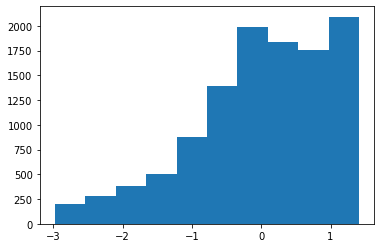

In [6]:
import matplotlib.pyplot as plt
plt.hist(age_trans)

(array([ 487.,  549.,  767., 1213., 1287., 1597., 1557., 1308., 1127.,
        1413.]),
 array([-2.22412619, -1.83814153, -1.45215688, -1.06617222, -0.68018757,
        -0.29420291,  0.09178175,  0.4777664 ,  0.86375106,  1.24973571,
         1.63572037]),
 <a list of 10 Patch objects>)

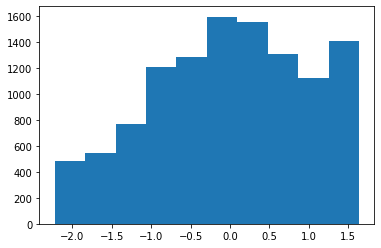

In [7]:
plt.hist(age_power)

In [8]:
from ast import literal_eval
df_merged['dx_seq_tok'] = df_merged['dx_seq_tok'].apply(lambda x: literal_eval(x))

In [9]:
pct_keep = 1
thresh=35
while pct_keep > 0.90:
    thresh += 1
    pct_keep = len(df_merged.dropna(thresh=thresh))/len(df_merged)

df_merged.dropna(thresh=thresh, inplace=True)

In [10]:
len(df_merged)

9930

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
import pickle as pkl

cat_encoder = OneHotEncoder()

cat_attribs = ['gender', 'unittype', 'unitadmitsource', 'ethnicity']
num_attribs = ['hr_min_w1', 'hr_max_w1', 'hr_mean_bl',
       'resp_min_w1', 'resp_max_w1', 'resp_mean_bl', 'sao2_min_w1',
       'hr_chg_bl', 'resp_chg_bl', 'noninv_mean_w1', 'noninv_mean_bl',
       'noninv_chg', 'noninv_syst_max_wl', 'noninv_syst_min_wl',
       'noninv_dias_max_wl', 'noninv_dias_min_wl', 'age', 'admissionweight', 
       'gluc_mean_bl', 'gluc_max_w1', 'gluc_min_w1', 'k_mean_bl', 'k_min_w2',
       'k_max_w2', 'na_mean_bl', 'na_min_w2', 'na_max_w2', 'hgb_mean_bl',
       'hgb_min_w2', 'cl_mean_bl', 'cl_min_w2', 'cl_max_w2', 'hct_min_w2',
       'crt_min_w2', 'crt_mean_w2', 'crt_max_w1', 'bun_mean_w1', 'ca_min_w2',
       'ca_max_w2', 'bicarb_mean_w1', 'wbc_max_w2', 'angap_max_w1',
       'angap_max_w2', 'hco3_min_w2', 'hco3_max_w2', 'pao2_min_w2',
       'paco2_max_w2', 'ph_min_w2', 'ph_max_w2', 'inr_max_w2', 'lymphs_max_w2',
       'lact_max_w2', 'alb_min_w2', 'tbili_max_w2', 'usg_max_w2',
       'fio2_mean_w2', 'plt_min_w2', 'rbc_max_w2', 'bun_crt_rat', 'crt_chg',
       'hgb_chg', 'k_chg', 'pao2_fio2_rat']

num_pipeline = Pipeline([
    
        ('std_scaler', StandardScaler()),
        ('imputer', SimpleImputer(strategy="mean")),
#         ('poly', PolynomialFeatures(degree=2, interaction_only=True))
    ])

full_pipeline = ColumnTransformer([
        ("cat", cat_encoder, cat_attribs),
        ("num", num_pipeline, num_attribs)],
        remainder='passthrough'
    )

# full_pipeline = pkl.load(open('../models/full_pipeline.pkl', 'rb'))

df_merged['patientunitstayid'] = df_merged.index
final_cols = ['dx_seq_tok'] + cat_attribs + num_attribs + ['label'] + ['patientunitstayid']
df_merged = df_merged[final_cols]
df_merged.replace([np.inf, -np.inf], np.nan, inplace=True)
df_merged.dropna(subset=cat_attribs, inplace=True)
full_pipeline.fit(df_merged)
df_merged_prepared = full_pipeline.transform(df_merged,)

In [31]:
y = df_merged_prepared[:, -2].astype(int)

# Stratified split

from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_index, test_index in sss.split(df_merged_prepared[:, :-2], y):
    X_train, X_test = df_merged_prepared[:, :-2][train_index], df_merged_prepared[:, :-2][test_index]
    y_train, y_test = y[train_index], y[test_index]


split = StratifiedShuffleSplit(n_splits=1, test_size=0.1)
for train_index, test_index in sss.split(X_train, y_train):
    X_train, X_val = X_train[train_index], X_train[test_index]
    y_train, y_val = y_train[train_index], y_train[test_index]

X_train_A, X_train_B = np.array(list(X_train[:,-1])), X_train[:,:-1].astype(float)
X_test_A, X_test_B = np.array(list(X_test[:,-1])), X_test[:,:-1].astype(float)
X_val_A, X_val_B = np.array(list(X_val[:,-1])), X_val[:,:-1].astype(float)

In [32]:
X_train.shape

(6355, 94)

In [33]:
def mortality(x_train, y_train, x_val, y_val, params):

    [X_train_A, X_train_B] = x_train
    [X_val_A, X_val_B] = x_val
    
    model_1 = tf.keras.Sequential()
    
    for i in range(params['hidden_layers']):
        model_1.add(tf.keras.layers.Dense(params['n_units'], activation='elu'))
        model_1.add(tf.keras.layers.Dropout(rate=params['rate']))
    
    model_1.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    model_1.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=params['learning_rate']),
                  metrics=[tf.keras.metrics.AUC()])

    es1 = EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True)

    # Numcat only
    history1 = model_1.fit(X_train_B,
                        y_train,
                        epochs=200,
                        batch_size=params['batch_size'],
                        validation_data=(X_val_B, y_val),
                        callbacks=[es1], verbose=0)

#     ## Model 2: RNN

#     model_2 = tf.keras.Sequential([
#         tf.keras.layers.Embedding(1000, params['embed_size']),
#         tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(params['LSTM_units'])),
        
#     ])
    
#     for j in range(params['rnn_hlayers']):
#         model_2.add(tf.keras.layers.Dense(params['n_units_rnn_dnn'], activation=params['activation']))
#         model_2.add(tf.keras.layers.Dropout(rate=params['rate']))
        
#     model_2.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
#     model_2.compile(loss='binary_crossentropy',
#                   optimizer='adam',
#                   metrics=[tf.keras.metrics.AUC()])


#     es2 = EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)


#     # Sequential only
#     history2 = model_2.fit(X_train_A,
#                         y_train,
#                         epochs=50,
#                         batch_size=params['batch_size'],
#                         validation_data=(X_val_A, y_val),
#                         callbacks=[es2], verbose=0)

#     # Remove last layer of models

#     model_1.pop()
#     model_2.pop()

#     ## Model 3: DNN + RNN

#     input_A = tf.keras.layers.Input(shape=(100,), name='seq_input')
#     seq_model = model_2(input_A)

#     input_B = tf.keras.layers.Input(shape=(X_train_B.shape[1],), name='feature_input')
#     catnum_model = model_1(input_B)

#     concat = tf.keras.layers.Concatenate()([seq_model, catnum_model])
    
#     hlayers = tf.keras.Sequential()
#     for k in range(params['comb_hlayers']):
#         hlayers.add(tf.keras.layers.Dense(params['comb_width'], activation=params['activation']))
#         hlayers.add(tf.keras.layers.Dropout(rate=params['rate']))
    
#     hidden1 = hlayers(concat)

#     output = tf.keras.layers.Dense(1, name="output", activation='sigmoid')(hidden1)
#     aux_output = tf.keras.layers.Dense(1, activation='sigmoid', name="aux_output")(catnum_model)

#     model_3 = tf.keras.Model(inputs=[input_A, input_B], outputs=[output, aux_output])

#     model_3.compile(loss=['binary_crossentropy','binary_crossentropy'],
#                   optimizer='adam',
#                   loss_weights=[0.9, 0.1],
#                   metrics=[tf.keras.metrics.AUC(), 'accuracy'])

#     es3 = EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)

#     history3 = model_3.fit([X_train_A, X_train_B],
#                         [y_train, y_train],
#                         epochs=30,
#                         batch_size=params['batch_size'],
#                         validation_data=([X_val_A, X_val_B],  [y_val, y_val]),
#                         callbacks=[es3], verbose=0)
    
    return history1, model_1

In [34]:
from tensorflow.keras.activations import relu, elu

# p = {
#     'hidden_layers' : [3],
#     'n_units' : [32],
#     'learning_rate' : [0.001],
#     'rate' : [0.4],
#     'embed_size' : [16],
#     'LSTM_units' : [32],
#     'rnn_hlayers' : [3],
#     'n_units_rnn_dnn' : [16],
#     'batch_size' : [128], #test
#     'comb_hlayers' : [1],
#     'comb_width' : [64]
# }

p = {
    'hidden_layers' : [1,],
    'n_units' : [64,],
    'learning_rate' : [0.0005,],
    'rate' : [ 0.5],
    'embed_size' : [32],
    'LSTM_units' : [16],
    'rnn_hlayers' : [2],
    'n_units_rnn_dnn' : [16],
    'batch_size' : [64,], #test
    'comb_hlayers' : [2],
    'comb_width' : [32],
    'activation' : ['elu']
}

In [ ]:
x=[X_train_A, X_train_B]
x_val = [X_val_A, X_val_B]
y=y_train

t = ta.Scan(x=x, y=y, x_val=x_val, y_val=y_val, params=p, 
            model=mortality, experiment_name='mortality')

  0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
# accessing the results data frame
t.data.head()

,round_epochs,loss,auc,val_loss,val_auc,LSTM_units,activation,batch_size,comb_hlayers,comb_width,embed_size,hidden_layers,learning_rate,n_units,n_units_rnn_dnn,rate,rnn_hlayers
0,149,0.426549,0.884319,0.448912,0.872402,16,elu,64,2,32,32,1,0.0005,64,16,0.5,2


In [19]:
# access the summary details
t.details

experiment_name               mortality
random_method          uniform_mersenne
reduction_method                   None
reduction_interval                   50
reduction_window                     20
reduction_threshold                 0.2
reduction_metric                val_acc
complete_time            10/08/19/22:10
x_shape                            list
y_shape                         (6355,)
dtype: object

In [20]:
# use Scan object as input
analyze_object = ta.Analyze(t)


In [21]:
# access the dataframe with the results
analyze_object.data

,round_epochs,loss,auc,val_loss,val_auc,LSTM_units,activation,batch_size,comb_hlayers,comb_width,embed_size,hidden_layers,learning_rate,n_units,n_units_rnn_dnn,rate,rnn_hlayers
0,149,0.426549,0.884319,0.448912,0.872402,16,elu,64,2,32,32,1,0.0005,64,16,0.5,2


In [22]:

# get the highest result for any metric
analyze_object.high('val_auc')


0.8724020719528198

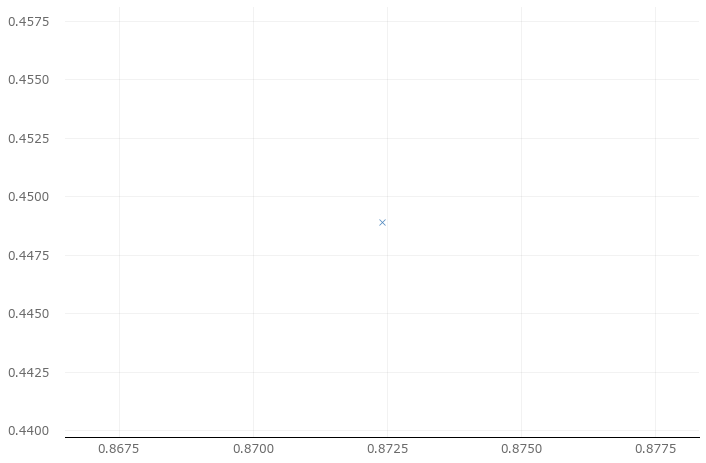

In [23]:
# a regression plot for two dimensions 
analyze_object.plot_regs('val_auc', 'val_loss')

In [24]:
# heatmap correlation
# analyze_object.plot_corr('val_output_loss', ['auc', 'loss', 'val_loss'])


In [25]:
res = analyze_object.data

In [26]:
res.sort_values(by='val_loss', ascending=True)

,round_epochs,loss,auc,val_loss,val_auc,LSTM_units,activation,batch_size,comb_hlayers,comb_width,embed_size,hidden_layers,learning_rate,n_units,n_units_rnn_dnn,rate,rnn_hlayers
0,149,0.426549,0.884319,0.448912,0.872402,16,elu,64,2,32,32,1,0.0005,64,16,0.5,2


In [27]:
import seaborn as sns

In [28]:
heatmap1_data = pd.pivot_table(res, values='val_loss', 
                     index=['learning_rate'], 
                     columns='batch_size')

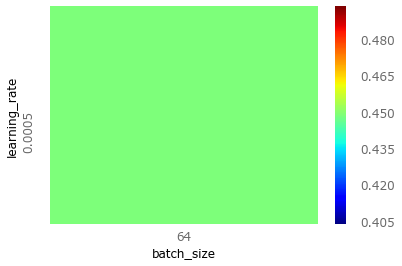

In [29]:
sns.heatmap(heatmap1_data, cmap='jet')

## 